In [6]:
try:
    import torch  
    print('Module torch was installed')
except ImportError:    
    print("Installinng torch 1.8.1")
    !pip install -q torch==1.8.1
    import qiskit  

try:
    import torchvision  
    print('Module torchvision was installed')
except ImportError:    
    print("Installinng torchvision 0.4.0")
    !pip install -q torchvision==0.4.0
    import qiskit  

try:
    import qiskit  
    print('Module qiskit was installed')
except ImportError:    
    print("Installinng qiskit 0.14.0")
    !pip install -q qiskit==0.14.0
    import qiskit  


import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import sys
import functools
from qiskit import  QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
import math

from lib_qiskit import *
from lib_dataloader import *

import qiskit

print = functools.partial(print, flush=True)


Module torch was installed
Module torchvision was installed
Module qiskit was installed


In [12]:
#define parameter
input_data_num =20
init_weight = torch.tensor([[1,1,1,-1]],dtype=torch.double)

def binary(input):
    output = input.new(input.size())
    output[input >= 0.1] = 1
    output[input < 0.1] = 0
    return output

#get correct result with no error
input_data = torch.rand(input_data_num,4,dtype=torch.double)
input_data_quantum_matrix = []
for i in range(input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])
    n1_q_gates,n1_idx =ULayerCircuit.qf_map_extract_from_weight(init_weight[0])
    input_data_quantum_matrix.append(quantum_matrix[n1_idx].view(-1))

input_data_quantum_matrix = torch.stack(input_data_quantum_matrix)
# print(input_data_quantum_matrix.t()[0:4].t())
# print(input_data_quantum_matrix)
correct_result =torch.mm(init_weight,input_data_quantum_matrix.t()[0:4])
correct_result = correct_result*correct_result/4
print(correct_result)
correct_result_binary = binary(correct_result.t())
print(correct_result_binary)


tensor([[0.0511, 0.0071, 0.0042, 0.3054, 0.1497, 0.0014, 0.0006, 0.0343, 0.0965,
         0.1622, 0.0141, 0.1100, 0.0007, 0.0953, 0.0025, 0.0005, 0.0076, 0.2125,
         0.0060, 0.0046]], dtype=torch.float64)
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]], dtype=torch.float64)


correct result  : tensor(1., dtype=torch.float64)
Result : 0.0


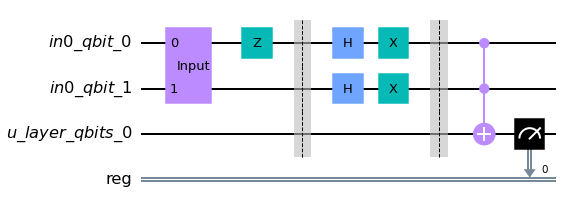

In [8]:
######################################################
#example of u-layer
i = 0
#transform input_data into u-Mat
quantum_matrix =to_quantum_matrix(input_data[i])

#generate u-layer
#define your input and output number
u_layer = ULayerCircuit(4,1) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_in_qubits(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
u_layer.forward(circuit,quantum_matrix,init_weight,inps,u_layer_out_qubits)

#measure
c_reg = ClassicalRegister(1,"reg")
circuit.add_register(c_reg)
circuit.measure(u_layer_out_qubits[0],c_reg[0])

#get the result
qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
(opt_mycount,bits) = analyze(opt_counts)
prob = float(opt_mycount[bits])/qc_shots

print("correct result  :",correct_result_binary[i][0])
print("Result :",prob)
circuit.draw('mpl',fold=50)


######################################################



In [9]:
circuit_result = []
for i in range(input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])
    
    #generate u-layer
    #define your input and output number
    u_layer = ULayerCircuit(4,1) 
    #init circuit
    circuit = QuantumCircuit()
    #add input qubit to your circuit
    inps = u_layer.add_in_qubits(circuit)
    
    #add output qubit to your circuit
    u_layer_out_qubits = u_layer.add_out_qubits(circuit)
    
    #add ulayer to your circuit
    u_layer.forward(circuit,quantum_matrix,init_weight,inps,u_layer_out_qubits)
    
    #measure
    c_reg = ClassicalRegister(1,"reg")
    circuit.add_register(c_reg)
    circuit.measure(u_layer_out_qubits[0],c_reg[0])
    
    #get the result
    qc_shots=100000
    opt_counts = fire_ibmq(circuit,qc_shots,True)
    opt_class_prob = []
    (opt_mycount,bits) = analyze(opt_counts)
    for b in range(bits):
        opt_class_prob.append(float(opt_mycount[b])/qc_shots)
    if opt_class_prob[0] >= 0.1 :
        circuit_result.append(1)
    else:
        circuit_result.append(0)

circuit_result_tensor = torch.tensor(circuit_result,dtype=torch.double)

print("correct_result_binary:",correct_result_binary.t())
print("circuit_result_tensor:",circuit_result_tensor)

correct_result_binary: tensor([[1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
         0., 1.]], dtype=torch.float64)
circuit_result_tensor: tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1.], dtype=torch.float64)
